# The `ParameterizedQuantity` Framework

The goal of this framework is to make it possible to take any parameter in *ARES* (the ones that take on numerical values, anyways), and convert it from a constant to a function of an arbitrary set of variables. 

One approach is to allow the user to supply a function of their own to each parameter in place of a numerical value. *ARES* permits this functionality for some parameters (e.g., ``pop_sed``), however, it is often advantageous to retain access to the parameters of the user-supplied function, for example to allow these parameters to vary in some fit. This is the primary motivation for the `ParameterizedQuantity` framework.

We have already seen PQs in use in the [More Realistic Galaxy Populations](example_pop_galaxy) example, which showed how to make the efficiency of star formation a function of halo mass:


In [1]:
%pylab inline
import ares
import numpy as np
import matplotlib.pyplot as pl

Populating the interactive namespace from numpy and matplotlib


In [2]:
pars = \
{
 'pop_sfr_model': 'sfe-func',
 'pop_sed': 'eldridge2009',
    
 'pop_fstar': 'pq',
 'pq_func': 'dpl',
 'pq_func_var': 'Mh',
 'pq_func_par0': 0.05,
 'pq_func_par1': 2.8e11,
 'pq_func_par2': 0.51,
 'pq_func_par3': -0.61,
 'pq_func_par4': 1e10,  # Halo mass at which fstar is normalized
}
    
pop = ares.populations.GalaxyPopulation(**pars)

There are three important steps shown above:

   + Setting ``pop_fstar='pq'`` tells *ARES* that this quantity will be represented by a PQ object. With no ID number supplied, it is assumed that parameters with the prefix ``pq`` are used to construct this object.
   + The function adopted is a double power-law, ``'dpl'``, which is a four-parameter model. The parameters ``pq_func_par0``, ``pq_func_par1``, etc. store the values of these parameters. The meaning of the parameters is of course different depending on what function we choose -- see [this listing](params_pq) of the available functions and their corresponding parameters.
   + The independent variable is halo mass, ``Mh``. Note that this name is important, i.e., just ``M`` will cause an error. This is a convention of the :class:`GalaxyCohort <ares.populations.GalaxyCohort.GalaxyCohort>` class.

Let's plot it just for a sanity check:

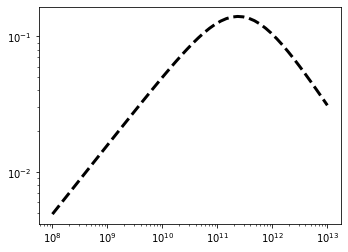

In [3]:
Mh = np.logspace(8, 13)
sfe_dpl = pop.fstar(z=6, Mh=Mh)

pl.loglog(Mh, sfe_dpl, color='k', ls='--', lw=3)

## Multi-Variable Parameterized Quantities

More complicated models are also available. For example, say we wanted to allow the normalization of the SFE to evolve with redshift, i.e.,

$$ f_{\ast}(M_h) = \frac{2 f_{\ast,0} \left(\frac{1+z}{7}\right)^{\gamma_z}} {\left(\frac{M_h}{M_{\text{p}}} \right)^{\gamma_{\text{lo}}} + \left(\frac{M_h}{M_{\text{p}}}  \right)^{\gamma_{\text{hi}}}} $$


Starting from the pure ``dpl`` model above, we can make a few modifications:

In [4]:
# Extra multiplicative boost with redshift, par0 * (var / par1)**par2
pars = \
{
 'pop_sfr_model': 'sfe-func',
 'pop_sed': 'eldridge2009',

 'pop_fstar': 'pq[0]',      # Give it an ID this time, since we'll add another
 'pq_func[0]': 'dpl_evolN', # dpl w/ evolution in the Normalization      
 'pq_func_var[0]': 'Mh',
 'pq_func_var2[0]': '1+z',  # indicate 1+z as the second indep. variable
	           
 # Old parameters that we still need
 'pq_func_par0[0]': 0.05,
 'pq_func_par1[0]': 2.8e11, 
 'pq_func_par2[0]': 0.51,
 'pq_func_par3[0]': -0.61,
 'pq_func_par4[0]': 1e10,
 'pq_func_par5[0]': 7.,     # New param: "pivot" redshift
 'pq_func_par6[0]': 1.,     # New param: PL evolution index
}

To verify that this has worked, let's again plot the SFE, now as a function of redshift, and compare to the previous $z$-independent model:


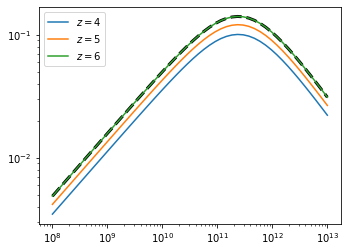

In [5]:
pop = ares.populations.GalaxyPopulation(**pars)

redshifts = [4,5,6]
Mh = np.logspace(8, 13)

pl.loglog(Mh, sfe_dpl, color='k', ls='--', lw=3)
for z in redshifts:
    fstar = pop.SFE(z=z, Mh=Mh)
    pl.loglog(Mh, fstar, label=r'$z={}$'.format(z))

pl.legend()

**NOTE:** The only method of ParameterizedQuantity objects ever called is the ``__call__`` method, which accepts ``**kwargs``. As a result, we must always supply arguments accordingly (i.e., supplying positional arguments only will not suffice), hence the ``z=z, Mh=Mh`` usage above.

## Multiple `ParameterizedQuantity` objects at once

In general, we can use the same approach outlined above to parameterize other quantities as a function of halo mass and/or redshift. For example, we can use a double power-law SFE model and set the escape fraction to be a step function in halo mass, 

In [6]:
pars = \
{
 'pop_sfr_model': 'sfe-func',
 'pop_sed': 'eldridge2009',
 
 'pop_fstar': 'pq[0]',
 'pq_func[0]': 'dpl',
 'pq_func_par0[0]': 0.05,
 'pq_func_par1[0]': 2.8e11,
 'pq_func_par2[0]': 0.5,
 'pq_func_par3[0]': -0.5,
 'pq_func_par4[0]': 1e10,

 'pop_fesc': 'pq[1]',
 'pq_func[1]': 'step_abs',
 'pq_func_par0[1]': 0.02,
 'pq_func_par1[1]': 0.2,
 'pq_func_par2[1]': 1e10,
}

Note that here we gave ID numbers for each PQ in square brackets, both when identifying the parameters to be treated as PQs (``pop_fstar`` and ``pop_fesc``) and when setting the values of their sub-parameters (e.g., ``pq_func[0]``, ``pq_func_par0[0]``, etc. 

To check the result:

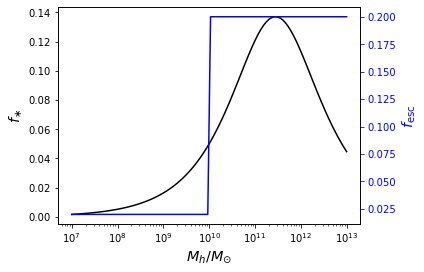

In [7]:
pop = ares.populations.GalaxyPopulation(**pars)

Mh = np.logspace(7, 13, 100)

fig, ax1 = pl.subplots(num=2)

ax1.semilogx(Mh, pop.fstar(z=6, Mh=Mh), color='k')
ax1.set_ylabel(r'$f_{\ast}$')
ax1.set_xlabel(r'$M_h / M_{\odot}$')
    
ax2 = ax1.twinx()
ax2.tick_params('y', colors='b')
ax2.set_ylabel(r'$f_{\mathrm{esc}}$', color='b')
ax2.semilogx(Mh, pop.fesc(z=6, Mh=Mh), color='b')

## Allowed Parameters

An incomplete list so far:

* ``pop_fstar``
* ``pop_fesc``
* ``pop_focc``